In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import date

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import asc, desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
# Declare a Base using `automap_base()`
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print("Example Information")
print(calc_temps('2012-02-28', '2012-03-05'))

Example Information
[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for matching dates from a previous year in the data set
startdate = "2017-08-01"
enddate = "2017-08-07"
print(f"Start Date: {startdate}")
print(f"End Date: {enddate}")
print("  TMIN, TAVE, TMAX  ")
temperature_data = calc_temps(startdate, enddate) 
print(calc_temps(startdate, enddate))

Start Date: 2017-08-01
End Date: 2017-08-07
  TMIN, TAVE, TMAX  
[(72.0, 79.25, 83.0)]


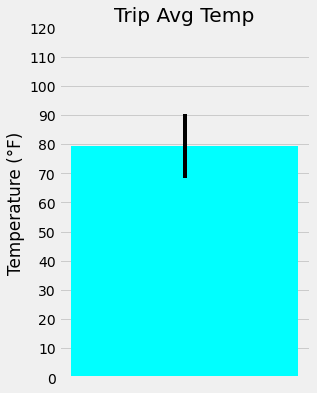

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
average_temperature = temperature_data[0][1]
bar_height = average_temperature
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
min_temperature = temperature_data[0][0]
max_temperature = temperature_data[0][2]
peak_to_peak = max_temperature - min_temperature
xpos = 1
# Plot bar chart based on data from above
plt.figure(figsize = (4,6))
plt.bar(xpos, bar_height, yerr = peak_to_peak, color = "cyan")
plt.xticks([])
plt.yticks(np.arange(0,130,10))
# Set the ylabel, chart title
plt.ylabel("Temperature (°F)")
plt.title("Trip Avg Temp")
# Show plot  
plt.show()

### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.

# Perform a query to retrieve the precipitation data
precipitation_data =  session.query(Measurement.station, Measurement.date, Measurement.prcp).\
              filter(Measurement.date >= startdate).filter(Measurement.date <= enddate).all()
# Create dataframe for precipitation per station ID per day
precipitation_data_df = pd.DataFrame(precipitation_data, columns = ["Station ID", "Date", "Precipitation"])
# Calculate total precipitation per station ID
precipitation_per_station_df = precipitation_data_df.groupby(precipitation_data_df["Station ID"]).sum()
precipitation_per_station_df.rename(columns = {"Precipitation" : "Total Precipitation"}, inplace = True)
# Perform a query to retrieve the staions information 
stations_data = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).all()
# Create a dataframe for conating the stations information
stations_data_df = pd.DataFrame(stations_data, columns = ["Station ID", "Name", "Latitude", "Longitude", "Elevation"])
# Set "Statios ID" as index
stations_data_df.set_index("Station ID", drop = True, inplace = True)
# Combine the total precipitation with the stations information
merged_df = pd.merge(stations_data_df, precipitation_per_station_df, left_index = True, right_index = True)
# Sort this in descending orer by precipitation amount and list the station, name, latitude, longitude, and elevation
merged_df.sort_values("Total Precipitation", ascending = False, inplace = True)
# Show dataframe
merged_df

,Name,Latitude,Longitude,Elevation,Total Precipitation
Station ID,,,,,
USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.36
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.22
USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.06
USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.04
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.00


### Daily Temperature Normals

In [13]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
print("Example Information")
daily_normals("01-01")

Example Information


[(62.0, 69.15384615384616, 77.0)]

In [14]:
# Calculate the daily normals for your trip
# Push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2018-08-01'
end_date = '2018-08-07'
# Convert dates in "str" to datetime format
end_date_dt_format = dt.datetime.strptime(end_date, '%Y-%m-%d')
start_date_dt_format = dt.datetime.strptime(start_date, '%Y-%m-%d')
# Use the start and end dates to create a range of dates for the trip
# Calculate date range
date_range = (end_date_dt_format-start_date_dt_format).days + 1
# Create list containing the dates of the trip
trip_dates = [start_date_dt_format + dt.timedelta(days = idx) for idx in range(date_range)]
# Display list containing the trip dates
trip_dates

[datetime.datetime(2018, 8, 1, 0, 0),
 datetime.datetime(2018, 8, 2, 0, 0),
 datetime.datetime(2018, 8, 3, 0, 0),
 datetime.datetime(2018, 8, 4, 0, 0),
 datetime.datetime(2018, 8, 5, 0, 0),
 datetime.datetime(2018, 8, 6, 0, 0),
 datetime.datetime(2018, 8, 7, 0, 0)]

In [15]:
# Strip off the year and save a list of strings in the format %m-%d
trip_days = []
for i in range(date_range):
    month = trip_dates[i].strftime("%m")
    day = trip_dates[i].strftime("%d")
    month_day = (month+"-"+day)
    trip_days.append(month_day)
# Display the list containing the month and day information of the trip dates
trip_days

['08-01', '08-02', '08-03', '08-04', '08-05', '08-06', '08-07']

In [16]:
# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = []
for day in trip_days:
    x = daily_normals(day)
    normals.append(x[0])
# Display the list aclled "normals"
normals   

[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0)]

In [17]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
# Create dataframe for "normals" list
normals_df = pd.DataFrame(normals, columns = ["tmin", "tavg", "tmax"])
# Create dataframe for "trip_dates" list
trip_dates_df = pd.DataFrame(trip_dates, columns = ["Date"])
# Merge the 2 dataframes above
trip_normals_df = pd.merge(trip_dates_df, normals_df,left_index = True, right_index = True)
trip_normals_df.set_index("Date", drop = True, inplace = True)
# Display the mmerged dataframe
trip_normals_df

,tmin,tavg,tmax
Date,,,
2018-08-01,67.0,75.540000,83.0
2018-08-02,68.0,75.603774,84.0
2018-08-03,70.0,76.611111,85.0
2018-08-04,69.0,76.711538,84.0
2018-08-05,69.0,76.148148,82.0
2018-08-06,67.0,76.250000,83.0
2018-08-07,71.0,77.156863,83.0


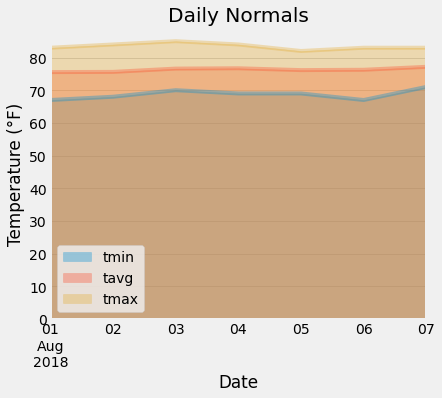

In [18]:
# Plot the daily normals as an area plot with `stacked=False`
# Create area plot
ax = trip_normals_df.plot(kind = "area", stacked = False, alpha =0.35, figsize = (6,5))
# Set the ylabel, chart title
plt.xlabel("Date")
plt.ylabel("Temperature (°F)")
plt.title("Daily Normals")
# Show plot 
plt.show()

## Close Session

In [19]:
# Close Session
session.close()